In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

In [6]:
# download files
!wget "http://data.insideairbnb.com/united-states/co/denver/2021-03-29/data/listings.csv.gz"
!wget "http://data.insideairbnb.com/united-states/co/denver/2021-03-29/data/calendar.csv.gz"
!wget "http://data.insideairbnb.com/united-states/co/denver/2021-03-29/data/reviews.csv.gz"

--2021-05-18 00:30:08--  http://data.insideairbnb.com/united-states/co/denver/2021-03-29/data/listings.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.217.0.122
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.217.0.122|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2498191 (2.4M) [application/x-gzip]
Saving to: ‘listings.csv.gz’

listings.csv.gz     100%[===================>]   2.38M  --.-KB/s    in 0.1s    

2021-05-18 00:30:09 (17.0 MB/s) - ‘listings.csv.gz’ saved [2498191/2498191]



In [35]:
# create dataframes
listings = pd.read_csv("/content/listings.csv.gz")
calendar = pd.read_csv("/content/calendar.csv.gz")
reviews = pd.read_csv("/content/reviews.csv.gz")

### listings data info

In [36]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3394 entries, 0 to 3393
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            3394 non-null   int64  
 1   listing_url                                   3394 non-null   object 
 2   scrape_id                                     3394 non-null   int64  
 3   last_scraped                                  3394 non-null   object 
 4   name                                          3394 non-null   object 
 5   description                                   3357 non-null   object 
 6   neighborhood_overview                         2592 non-null   object 
 7   picture_url                                   3394 non-null   object 
 8   host_id                                       3394 non-null   int64  
 9   host_url                                      3394 non-null   o

In [37]:
listings.sample(5)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
1722,35520755,https://www.airbnb.com/rooms/35520755,20210329150448,2021-03-31,Quiet Denver Oasis near Downtown,This space is a quiet little Oasis just outsi...,The neighborhood is a quaint little neighborho...,https://a0.muscache.com/pictures/ad9077d7-3a58...,117798889,https://www.airbnb.com/users/show/117798889,Sarah,2017-02-23,"Denver, Colorado, United States",NaN,within an hour,97%,100%,t,https://a0.muscache.com/im/pictures/user/72ef2...,https://a0.muscache.com/im/pictures/user/72ef2...,Athmar Park,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Denver, Colorado, United States",Athmar Park,NaN,39.70462,-105.01806,Entire guest suite,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Wifi"", ""Carbon monoxide alarm"", ""Microwave"",...",$85.00,1,29,1,1,1125,1125,1.0,1125.0,NaN,t,2,3,11,84,2021-03-31,142,97,6,2019-07-15,2021-03-26,97.0,10.0,10.0,10.0,10.0,10.0,9.0,2019-BFN-0008788,t,1,1,0,0,6.81
790,19984748,https://www.airbnb.com/rooms/19984748,20210329150448,2021-03-31,Charming garden level suite with private entrance,The Nest is nestled in a prime location near s...,"Cory-Merrill is a HOT neighborhood, just havin...",https://a0.muscache.com/pictures/7bd789f1-c7a4...,125745643,https://www.airbnb.com/users/show/125745643,Polly,2017-04-13,"Denver, Colorado, United States",After years of travel I have settled seamlessl...,within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/d55d7...,https://a0.muscache.com/im/pictures/user/d55d7...,Cory - Merrill,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'wor...",t,f,"Denver, Colorado, United States",Cory - Merrill,NaN,39.68798,-104.94400,Entire house,Entire home/apt,2,NaN,1 bath,2.0,3.0,"[""Wifi"", ""Kitchen"", ""Carbon monoxide alarm"", ""...",$100.00,2,60,2,2,1125,1125,2.0,1125.0,NaN,t,1,1,1,1,2021-03-31,52,14,1,2017-12-23,2021-03-17,97.0,10.0,10.0,10.0,10.0,10.0,10.0,2019-BFN-0010225,t,1,1,0,0,1.31
542,15409638,https://www.airbnb.com/rooms/15409638,20210329150448,2021-03-31,Modern 3800 sqft Downtown Loft w/ 2000 sqft Pa...,Professionally Managed Property: License #2019...,“From its early beginnings during the Gold Rus...,https://a0.muscache.com/pictures/c4253bdb-6825...,98259634,https://www.airbnb.com/users/show/98259634,Melanie,2016-10-05,"Denver, Colorado, United States",NaN,within an hour,84%,100%,t,https://a0.muscache.com/im/pictures/user/ea3ec...,https://a0.muscache.com/im/pictures/user/ea3ec...,CBD,7.0,7.0,"['email', 'phone', 'google', 'reviews', 'jumio...",t,f,"Denver, Colorado, United States",CBD,NaN,39.74085,-104.99289,Entire condominium,Entire home/apt,12,NaN,2.5 baths,3.0,4.0,"[""Elevator"", ""Wifi"", ""Kitchen"", ""Carbon monoxi...",$446.00,2,1125,2,2,1125,

## Data Cleaning


### Bathroom field  
- Bathrooms field is empty, bathrooms_text field is string info. 
- cleaning and breaking down bathrooms_text field, 
  - fill 'bathrooms' field with bathroom count 
  - add boolean 'shared_bath' field, True for shared bath, and False for private bath


In [38]:
# 'bathrooms' field is empty, 'bathrooms_text' field is object type with string info. 
# cleaning and breaking down 'bathrooms_text' field, fill 'bathrooms' field with bathroom count and add bool 'privat_bath' field

listings.bathrooms_text.replace({'Shared half-bath': '0.5 shared','Half-bath':'0.5 bath'}, regex=True, inplace=True)
bathroom_type = listings.bathrooms_text.str.split(" ")
print(f"listings.bathrooms_text:\n{listings.bathrooms_text.value_counts()}\n")

# privat_bath is True if text 'shared' is in bathrooms_text field. 
listings['shared_bath'] = bathroom_type.str.contains('shared',regex=False)
print(f"shared_bath:{listings.shared_bath.dtype}\n{listings.shared_bath.value_counts()}\n")

# bathroom counts in 'bathrooms' field and convert to numeric
listings['bathrooms'] = pd.to_numeric(bathroom_type.str[0])
print(f"bathrooms type: {listings.bathrooms.dtype}")
listings.bathrooms.value_counts()

listings.bathrooms_text:
1 bath              1822
2 baths              458
1 private bath       264
1 shared bath        177
2.5 baths            174
1.5 baths            156
3 baths              104
3.5 baths             75
1.5 shared baths      46
2 shared baths        38
4 baths               28
4.5 baths             19
4 shared baths         9
5 baths                8
17 baths               4
0.5 shared             3
10.5 baths             1
0 baths                1
0.5 bath               1
5.5 baths              1
6.5 baths              1
Name: bathrooms_text, dtype: int64

shared_bath:object
False    3117
True      273
Name: shared_bath, dtype: int64

bathrooms type: float64


1.0     2263
2.0      496
1.5      202
2.5      174
3.0      104
3.5       75
4.0       37
4.5       19
5.0        8
17.0       4
0.5        4
0.0        1
10.5       1
6.5        1
5.5        1
Name: bathrooms, dtype: int64

### Fill in NA


1. "Bedroom" field with blank are the ones that either a studio, or an open space without separate room as a bedroom, so we fill it with 0.
2. "Beds" field with blank typically means that the listings host missed the field. The main point of airbnb is bed, we'd assume they have at least 1 bed, so fill in the blank ones with 1. 
3. "Reviews_per_month" field with blank means there's no review at all. Thus, the "first_review" and "last_review" fields are both blank. We'd fill the "reviews_per_month" with 0.




In [39]:
pd.set_option('display.max_rows',None)
listings.isna().sum()

id                                                 0
listing_url                                        0
scrape_id                                          0
last_scraped                                       0
name                                               0
description                                       37
neighborhood_overview                            802
picture_url                                        0
host_id                                            0
host_url                                           0
host_name                                        151
host_since                                       151
host_location                                    158
host_about                                      1364
host_response_time                               471
host_response_rate                               471
host_acceptance_rate                             384
host_is_superhost                                151
host_thumbnail_url                            

In [40]:
# FunctionTransformer for cleaning 
from sklearn.preprocessing import FunctionTransformer
def custom_transformation(df):
  df.bedrooms.fillna(0, inplace=True)
  df.beds.fillna(1, inplace=True)
  df.reviews_per_month.fillna(0, inplace=True)

ft = FunctionTransformer(func=custom_transformation, validate=False)
ft.fit_transform(listings)


In [41]:
listings.isna().sum()

id                                                 0
listing_url                                        0
scrape_id                                          0
last_scraped                                       0
name                                               0
description                                       37
neighborhood_overview                            802
picture_url                                        0
host_id                                            0
host_url                                           0
host_name                                        151
host_since                                       151
host_location                                    158
host_about                                      1364
host_response_time                               471
host_response_rate                               471
host_acceptance_rate                             384
host_is_superhost                                151
host_thumbnail_url                            

In [42]:
listings.nunique()

id                                              3394
listing_url                                     3394
scrape_id                                          1
last_scraped                                       8
name                                            3235
description                                     3115
neighborhood_overview                           2266
picture_url                                     3269
host_id                                         2272
host_url                                        2272
host_name                                       1176
host_since                                      1536
host_location                                    133
host_about                                      1382
host_response_time                                 4
host_response_rate                                42
host_acceptance_rate                              73
host_is_superhost                                  2
host_thumbnail_url                            

### Dropping data


1. There is 1 record with price = 0, which would be dropped.
2. There are 404 records with first_review blank, which may mean that these listingss have never been rented out. (pending for discussion)
3. Drop all NA columns 'neighbourhood_group_cleansed','calendar_updated'
4. There are 4 records with NA in both bathrooms_text and bathrooms fields. 
5. 3 records with NA in host_identity_verified can be dropped as these may not be verified to be trust worthy hosts. 





In [43]:
print(f"initial listings df shpe: {listings.shape}")
# drop the record with price = 0
listings = listings[listings['price']!='$0.00']

# drop all na columns
listings.drop(['neighbourhood_group_cleansed','calendar_updated'], axis=1, inplace=True)

# drop bathrooms_text with na
listings.dropna(subset=['bathrooms_text'], inplace=True)

listings.dropna(subset=['host_identity_verified'], inplace=True)

print(f"after dropping listings df shape: {listings.shape}")

initial listings df shpe: (3394, 75)
after dropping listings df shape: (3239, 73)


In [44]:
listings.isna().sum()

id                                                 0
listing_url                                        0
scrape_id                                          0
last_scraped                                       0
name                                               0
description                                       33
neighborhood_overview                            779
picture_url                                        0
host_id                                            0
host_url                                           0
host_name                                          0
host_since                                         0
host_location                                      7
host_about                                      1210
host_response_time                               318
host_response_rate                               318
host_acceptance_rate                             231
host_is_superhost                                  0
host_thumbnail_url                            

### Price Field

price field is with type: object. It needs to remove '$' and ',' then convert to numeric.

In [45]:
# remove '$' and ','
listings['price'] = listings['price'].str.strip('$')
listings['price'] = listings['price'].str.replace(',', '')

# convert to numeric
listings['price'] = pd.to_numeric(listings['price'])

listings['price'].describe()



count    3239.000000
mean      157.894412
std       249.079138
min        22.000000
25%        79.000000
50%       115.000000
75%       175.000000
max      9999.000000
Name: price, dtype: float64

In [46]:
listings.neighbourhood_cleansed.value_counts()

Five Points                     255
Highland                        197
CBD                             162
Union Station                   125
Capitol Hill                    120
Gateway - Green Valley Ranch    119
West Highland                   113
West Colfax                     113
Speer                            98
Berkeley                         92
Sunnyside                        90
Baker                            88
City Park West                   78
Sloan Lake                       72
Stapleton                        72
Congress Park                    70
Cheesman Park                    69
Whittier                         67
Cole                             64
Civic Center                     64
Jefferson Park                   53
Lincoln Park                     47
Washington Park West             46
North Park Hill                  42
Platt Park                       42
North Capitol Hill               41
City Park                        40
Skyland                     

In [47]:
listings.room_type.value_counts()

Entire home/apt    2623
Private room        567
Hotel room           25
Shared room          24
Name: room_type, dtype: int64

In [48]:
listings.bedrooms.value_counts()

1.0     1595
2.0      900
3.0      332
0.0      221
4.0      117
5.0       51
6.0       18
7.0        2
16.0       1
9.0        1
8.0        1
Name: bedrooms, dtype: int64

In [49]:
listings.beds.value_counts()

1.0     1384
2.0      933
3.0      445
4.0      185
5.0       87
6.0       67
0.0       55
8.0       25
7.0       23
10.0      13
9.0       11
11.0       3
13.0       3
16.0       2
12.0       2
70.0       1
Name: beds, dtype: int64

In [50]:
listings.has_availability.value_counts()

t    3232
f       7
Name: has_availability, dtype: int64

## Review price field

The price field has a minimum of 10.0 per night and a maximum of 9,999.0 per night. 
The mean is $153.26, the median is 104.0 and 75% quatile of the price field is 167.75. This tells us the the distribution of the price field would skew right (positive skewed).  We could consider the majory of the listings records (3093 out of 3170) with price witin 500 and leave out 77 listings records that have price higher than 500. 

count    3239.000000
mean      157.894412
std       249.079138
min        22.000000
25%        79.000000
50%       115.000000
75%       175.000000
max      9999.000000
Name: price, dtype: float64


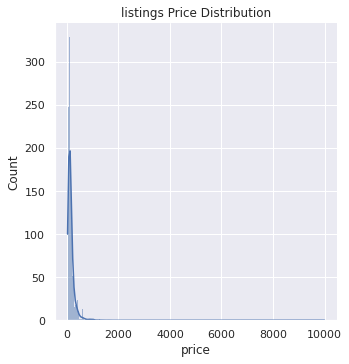

In [51]:
print(listings['price'].describe())

sns.displot(listings.price, kde=True).set(title='listings Price Distribution')


In [52]:

(listings['price']<=500).value_counts()

True     3156
False      83
Name: price, dtype: int64

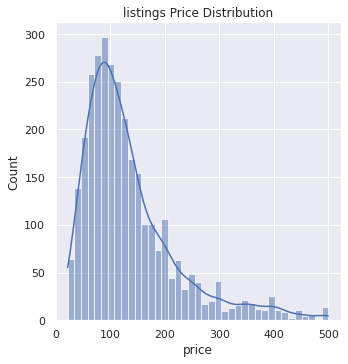

In [53]:

listings_price_500 = listings[listings['price']<=500]
sns.displot(listings_price_500.price, kde=True).set(title = 'listings Price Distribution')

In [54]:
listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,3.239000e+03,3.239000e+03,3.239000e+03,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3.239000e+03,3239.000000,3.239000e+03,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,2667.000000,2647.000000,2647.000000,2647.000000,2647.000000,2647.000000,2647.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000
mean,3.174935e+07,2.021033e+13,1.200190e+08,67.440877,67.440877,39.741726,-104.975334,4.108984,1.461717,1.626737,2.145724,157.894412,17.864464,596.468046,17.488422,20.688484,849.952454,6.638738e+05,20.315499,6.623624e+05,8.450448,21.760420,37.240506,160.879592,54.898117,13.599568,1.219203,96.807274,9.834907,9.760861,9.898376,9.883264,9.854552,9.665281,10.160852,9.169805,0.724298,0.137697,1.831405
std,1.420176e+07,0.000000e+00,1.227219e+08,263.235222,263.235222,0.030863,0.059978,2.651146,0.949099,1.098278,2.022359,249.079138,27.081258,506.504082,26.909712,50.995793,443.295997,3.773325e+07,49.825516,3.764749e+07,10.105310,20.755392,31.437849,128.764259,86.353552,20.574978,2.095641,5.723923,0.575007,0.632822,0.474466,0.532727,0.478961,0.677753,29.085884,29.107820,2.830981,1.283788,2.059973
min,1.770000e+02,2.021033e+13,6.150000e+02,0.000000,0.000000,39.611480,-105.100760,1.000000,0.000000,0.000000,0.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.102736e+07,2.021033e+13,1.833218e+07,1.000000,1.000000,39.729320,-105.011350,2.000000,1.000000,1.000000,1.000000,79.000000,2.000000,31.000000,2.000000,2.000000,365.000000,3.650000e+02,2.000000,3.650000e+02,0.000000,1.000000,5.000000,41.000000,2.000000,0.000000,0.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,1.000000,1.000000,0.000000,0.000000,0.220000
50%,3.519697e+07,2.021033e+13,6.513341e+07,1.000000,1.000000,39.747260,-104.984760,4.000000,1.000000,1.000000,2.000000,115.000000,4.000000,365.000000,3.000000,4.000000,1125.000000,1.125000e+03,4.000000,1.125000e+03,4.000000,17.000000,31.000000,137.000000,19.000000,4.000000,0.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,0.000000,0.000000,1.090000
75%,4.505420e+07,2.021033e+13,2.096038e+08,4.000000,4.000000,39.761995,-104.960055,5.000000,2.000000,2.000000,3.000000,175.000000,30.000000,1125.000000,30.000000,30.000000,1125.000000,1.125000e+03,30.000000,1.125000e+03,15.000000,39.000000,65.000000,290.500000,70.000000,19.000000,2.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000,2.000000,0.000000,0.000000,2.845000
max,4.892272e+07,2.021033e+13,3.937389e+08,2232.000000,2232.000000,39.816270,-104.735030,16.000000,17.000000,16.000000,70.000000,9999.000000,500.000000,1125.000000,500.000000,730.000000,1125.000000,2.147484e+09,711.800000,2.142603e+09,30.000000,60.000000,90.000000,365.000000,851.000000,190.000000,17.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

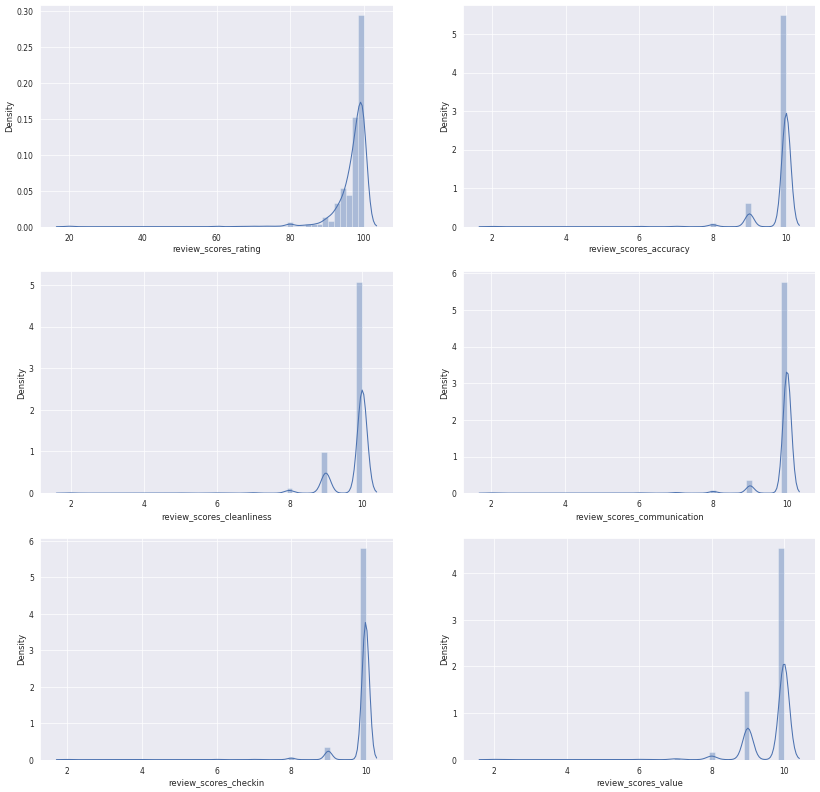

In [55]:
fig, axs = plt.subplots(3, 2, figsize=(20, 20), dpi=50)

sns.distplot(listings["review_scores_rating"], ax=axs[0, 0])
sns.distplot(listings["review_scores_accuracy"], ax=axs[0, 1])
sns.distplot(listings["review_scores_cleanliness"], ax=axs[1, 0])
sns.distplot(listings["review_scores_communication"], ax=axs[1, 1])
sns.distplot(listings["review_scores_checkin"], ax=axs[2, 0])
sns.distplot(listings["review_scores_value"], ax=axs[2, 1])

In [57]:
# Top listings area

listings.neighbourhood_cleansed.value_counts().head(10)

Five Points                     255
Highland                        197
CBD                             162
Union Station                   125
Capitol Hill                    120
Gateway - Green Valley Ranch    119
West Highland                   113
West Colfax                     113
Speer                            98
Berkeley                         92
Name: neighbourhood_cleansed, dtype: int64

## add in Neighbourhood group info

In [58]:
# Denver Neighborhood info https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Denver#Central

neighbourhoods_group = pd.read_csv("https://docs.google.com/spreadsheets/d/1EhAbM7f115MAFsDZxrbCTX4Dr4Nrq_yGQdgRfizTeVM/export?format=csv")
# neighbourhoods_group.dropna(inplace=True)
# neighbourhoods_group.neighbourhood_cleansed.str.strip()
# listings.neighbourhood_cleansed.str.strip()

listings = pd.merge(listings, neighbourhoods_group, on='neighbourhood_cleansed',  
         how='left', validate='m:1')

listings[['neighbourhood_cleansed','neighbourhood_group']].sample(5)


,neighbourhood_cleansed,neighbourhood_group
1194,Clayton,North
2369,Cole,North
1564,CBD,Central
2685,Five Points,North
2457,College View - South Platte,South


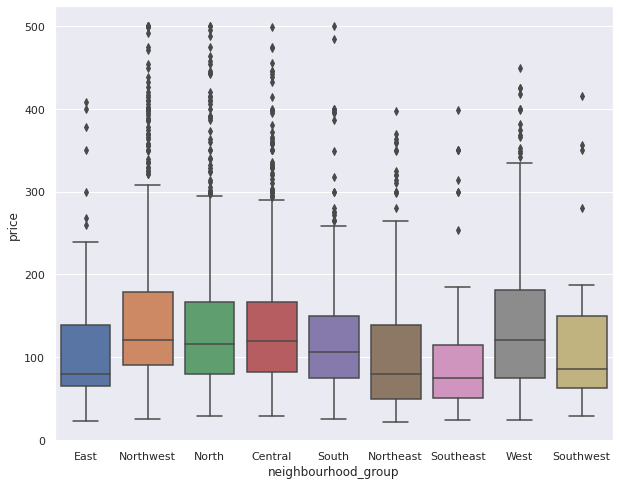

In [65]:
sns.boxplot(y='price',x='neighbourhood_group', data = listings[listings['price']<=500])
# neighbourhood_group.price.dtype

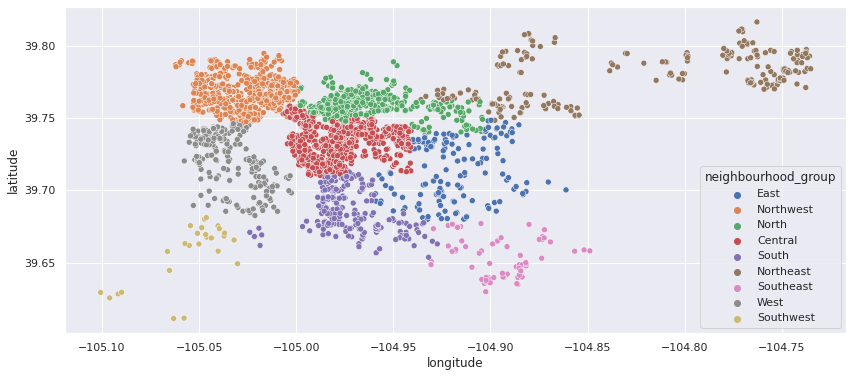

In [60]:
plt.figure(figsize=(14,6))
sns.scatterplot(data=listings, x='longitude', y='latitude', hue='neighbourhood_group')

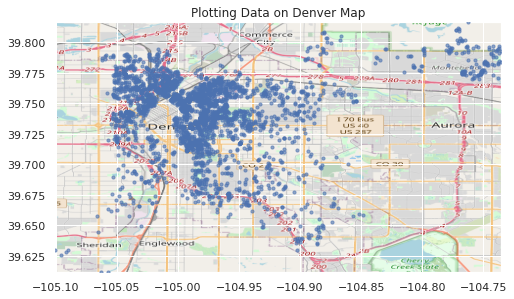

In [61]:
# map

denver_map = plt.imread('/content/map.png')

# denver_map = plt.imread('https://drive.google.com/file/d/1gjA5-9D_lYkOVyR624-4P-LFC2H5kSX0','png')
fig, ax = plt.subplots(figsize = (8,20))
ax.scatter(listings.longitude, listings.latitude, zorder=5, alpha= 0.6, c='b', s=10)
ax.set_title('Plotting Data on Denver Map')
ax.set_xlim(listings.longitude.min(),listings.longitude.max())
ax.set_ylim(listings.latitude.min(),listings.latitude.max())
# box_range = (listings.longitude.min(),listings.longitude.max(),listings.latitude.min(),listings.latitude.max())
box_range = (-105.3102,-104.5672, 39.5722, 39.9412)
ax.imshow(denver_map, zorder=0, extent = box_range, aspect= 'equal')



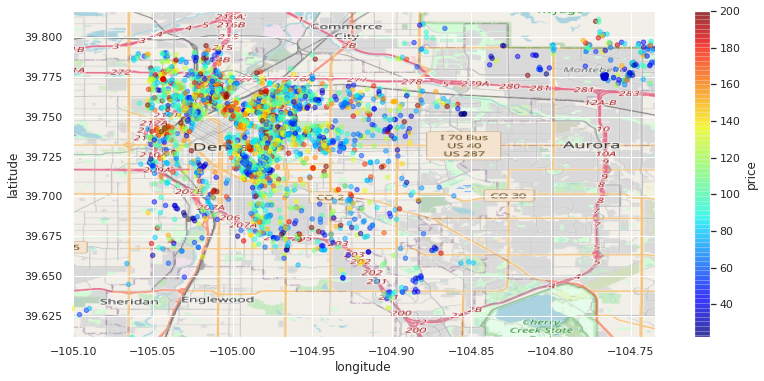

In [62]:
plt.figure(figsize=(14,6))
den_img = plt.imread("/content/map.png")

# plt.imshow(den_img, zorder=0, extent=[-105.3102,-104.5672, 39.5722, 39.9412])
plt.imshow(denver_map, zorder=0, extent = box_range, aspect= 'equal')

ax = plt.gca()

ax.set_xlim(listings.longitude.min(),listings.longitude.max())
ax.set_ylim(listings.latitude.min(),listings.latitude.max())

listings[listings['price']<=200].plot(kind='scatter', x='longitude', y='latitude', c='price', ax=ax,
             cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.5, zorder=5)

## reviews data

In [63]:
reviews.info
calendar.info